# **Multi-Step LSTM Time-Series Forecasting Models for Power Usage**

**Data Background**

* The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption (with a one-minute sampling rate) for a single household over four years

* The data contains 2,075,259 observations and 8 features (including timestamp) collected from a house in France between December 2006 and November 2010


**Data Dictionary**

|Variable|Definition|
|:---|:---|
|Datetime|yyyy-mm-dd hh:mm:ss
|Global_active_power|The total active power in kilowatts (kW) consumed by the household
|Global_reactive_power|The total reactive power in kilowatts (kW) consumed by the household
|Voltage|Average voltage (V)
|Global_intensity|Average current intensity (A)
|Sub_metering_1|Active energy for kitchen in watt-hours (Wh)
|Sub_metering_2|Active energy for laundry in watt-hours (Wh)
|Sub_metering_3|Active energy for climate control systems in watt-hours (Wh)
|Sub_metering_4$^{1}$|Active energy in watt-hours (Wh)

# 2. Business question

* What is the expected household power usage for each day over the next seven days?

---

Exploratory data analysis, insights drawn from it and time-series modelling can be summarized as follows: 

|||
|:---|:---|
|**Initial data exploration:**|* The data set contains 8 features (including time) and 2,075,259 observations
||* Column names were cleaned (strings to lower case)
||* '?' were replaced with missing values ('NaN')
||* Object datatypes were converted to float, all datatypes ended up being float
||* Missing values (25,979 per feature) were imputed with a value at the same time one day ago
||* A new feature 'sub_metering_4' was created, because the total energy consumption was larger than the sum of the three sub meters combined. The new feature was calculated as follows: global_active_power * 1000/60 - (sub_metering_1 + sub_metering_2 + sub_metering_3)
||* Dataset spans 1441 days (2006-12-16 to 2010-11-26)
||
|**Data visualization:**|* 'voltage' is a constant and can therefore be dropped for subsequent analysis
||**Histograms:**
||* 'global_active_power' (power consumption) data was converted from per-minute sampling (2,075,259 observations) into total daily consumption (1442 observations)
||* Target variable 'global_active_power' (total daily power consumption) is almost normally distributed with a slight positive skew
||**Time series:**
||* Target variable 'global_active_power' (total daily power consumption): time-series is stationary and shows seasonality. However, variance shows some variability. Exclude the first 5 months for modelling?
||**Correlation heatmap:**
||* 'global_intensity' is highly correlated with other features and should therefore be dropped before modelling
||
|**Test for stationarity:**|* Augmented Dicky-Fuller test concluded that the time series is stationary
||
|**Modelling:**|* A total of 4 multi-step LSTM prediction models were used, two based on univariate and two based on multivariate analysis
||* For each analysis, two main types of LSTM models for multi-step forecasting were employed: Vector Output Model (Stacked LSTM) and Encoder-Decoder Model
||* Data was split into 75% train (1082 observations) and 25% test (360 observations)
||* The data was scaled using mean and standard deviation of the train set
||* A sliding window approach was used to create multiple input/output samples (X, y) from the time-series sequence
||* 14 days of past observations (input X) were used to forecast a 7-day period (output y), i.e. 1062 train and 340 test samples were created with 14 timesteps for X and 7 timesteps for y each 
||* Models were optimized using a loss function and learning curves were plotted showing training and validation loss
||* Model prediction was performed on elements of the test set and plotted against actual data
||* Evaluation metric RMSE was used to compare model performance 
||* Under the current conditions employed (i.e., number of input/output steps, model definitions, etc.), univariate models performed slightly better than multivariate models. However, it must be noted that the **models had not been tuned**, only the number of nodes were adjusted to reduce over-fitting
||

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from matplotlib.ticker import StrMethodFormatter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('data\household_power_consumption.txt', sep=';', header=0, low_memory=False,
                infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=0)

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.tail(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0
2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0


In [5]:
df.shape

(2075259, 7)

In [6]:
df.columns=df.columns.str.lower()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    object 
 1   global_reactive_power  object 
 2   voltage                object 
 3   global_intensity       object 
 4   sub_metering_1         object 
 5   sub_metering_2         object 
 6   sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
global_active_power,2075259,4187,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_reactive_power,2075259,533,0.000,481561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voltage,2075259,2838,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_intensity,2075259,222,1.000,172785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_1,2075259,89,0.000,1880175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_2,2075259,82,0.000,1436830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_3,2049280.0,NaN,NaN,NaN,6.458447,8.437154,0.0,0.0,1.0,17.0,31.0


In [9]:
df.replace('?','Nan',inplace=True)

In [10]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
global_active_power,2075259,4187,Nan,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_reactive_power,2075259,533,0.000,481561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voltage,2075259,2838,Nan,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_intensity,2075259,222,1.000,172785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_1,2075259,89,0.000,1880175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_2,2075259,82,0.000,1436830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_3,2049280.0,NaN,NaN,NaN,6.458447,8.437154,0.0,0.0,1.0,17.0,31.0


- Convert the type of Data from object to Float

In [11]:
df=df.astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    float64
 1   global_reactive_power  float64
 2   voltage                float64
 3   global_intensity       float64
 4   sub_metering_1         float64
 5   sub_metering_2         float64
 6   sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122
global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194,1.390
voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890,254.150
global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400,48.400
sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000,88.000
sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000,80.000
sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000,31.000


In [13]:
df.isna().sum()

global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64

## Filling the missing values with the value at same time on a day ago

<Axes: ylabel='datetime'>

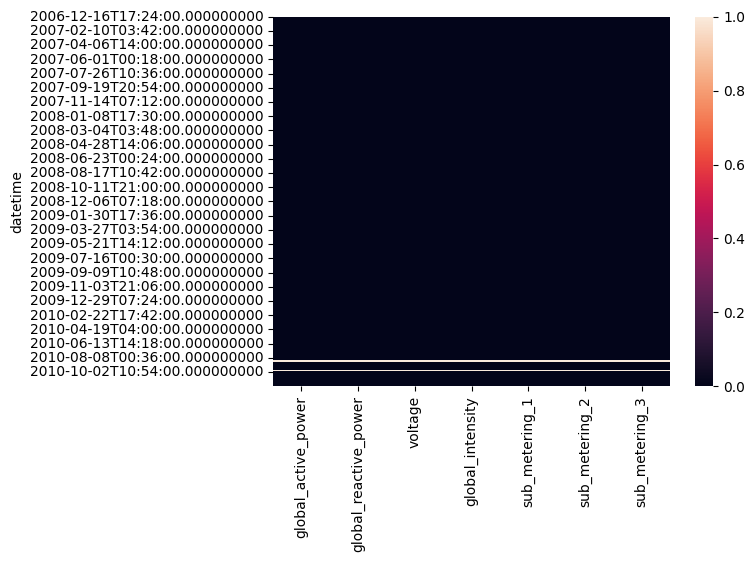

In [14]:
sns.heatmap(df.isnull())

In [15]:
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [16]:
df.isnull().sum()

global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64

In [17]:
# Fill missing values and check
fill_missing(df.values)
df.isna().sum().sum()

181853

In [18]:
df.isna().sum().sum()

181853

The total energy consumption was larger than the sum of the three sub meters combined. Therefore, add a new feature `'sub_metering_4'` will be added according to the following calculation: `global_active_power * 1000/60 - (sub_metering_1 + sub_metering_2 + sub_metering_3)`

In [19]:
df['sub_metering_4']=(df.iloc[:, 0] * 1000 / 60)-(df.iloc[:,4]+df.iloc[:,5]+df.iloc[:,6])

In [20]:
df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528000,11.122000
global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194000,1.390000
voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890000,254.150000
global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400000,48.400000
sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000000,88.000000
sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000000,80.000000
sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000000,31.000000
sub_metering_4,2049280.0,9.314693,9.585916,-2.400,3.800,5.500,10.366667,124.833333


In [22]:
df.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='datetime', length=2075259, freq=None)

In [23]:
print(f'Dataset Started {df.index.min()}')
print(f'Dataset End {df.index.max()}')
print(f'Dataset Spans {df.index.max()-df.index.min()}')

Dataset Started 2006-12-16 17:24:00
Dataset End 2010-11-26 21:02:00
Dataset Spans 1441 days 03:38:00


### ➡️Plotting data based on one-minute sampling rate

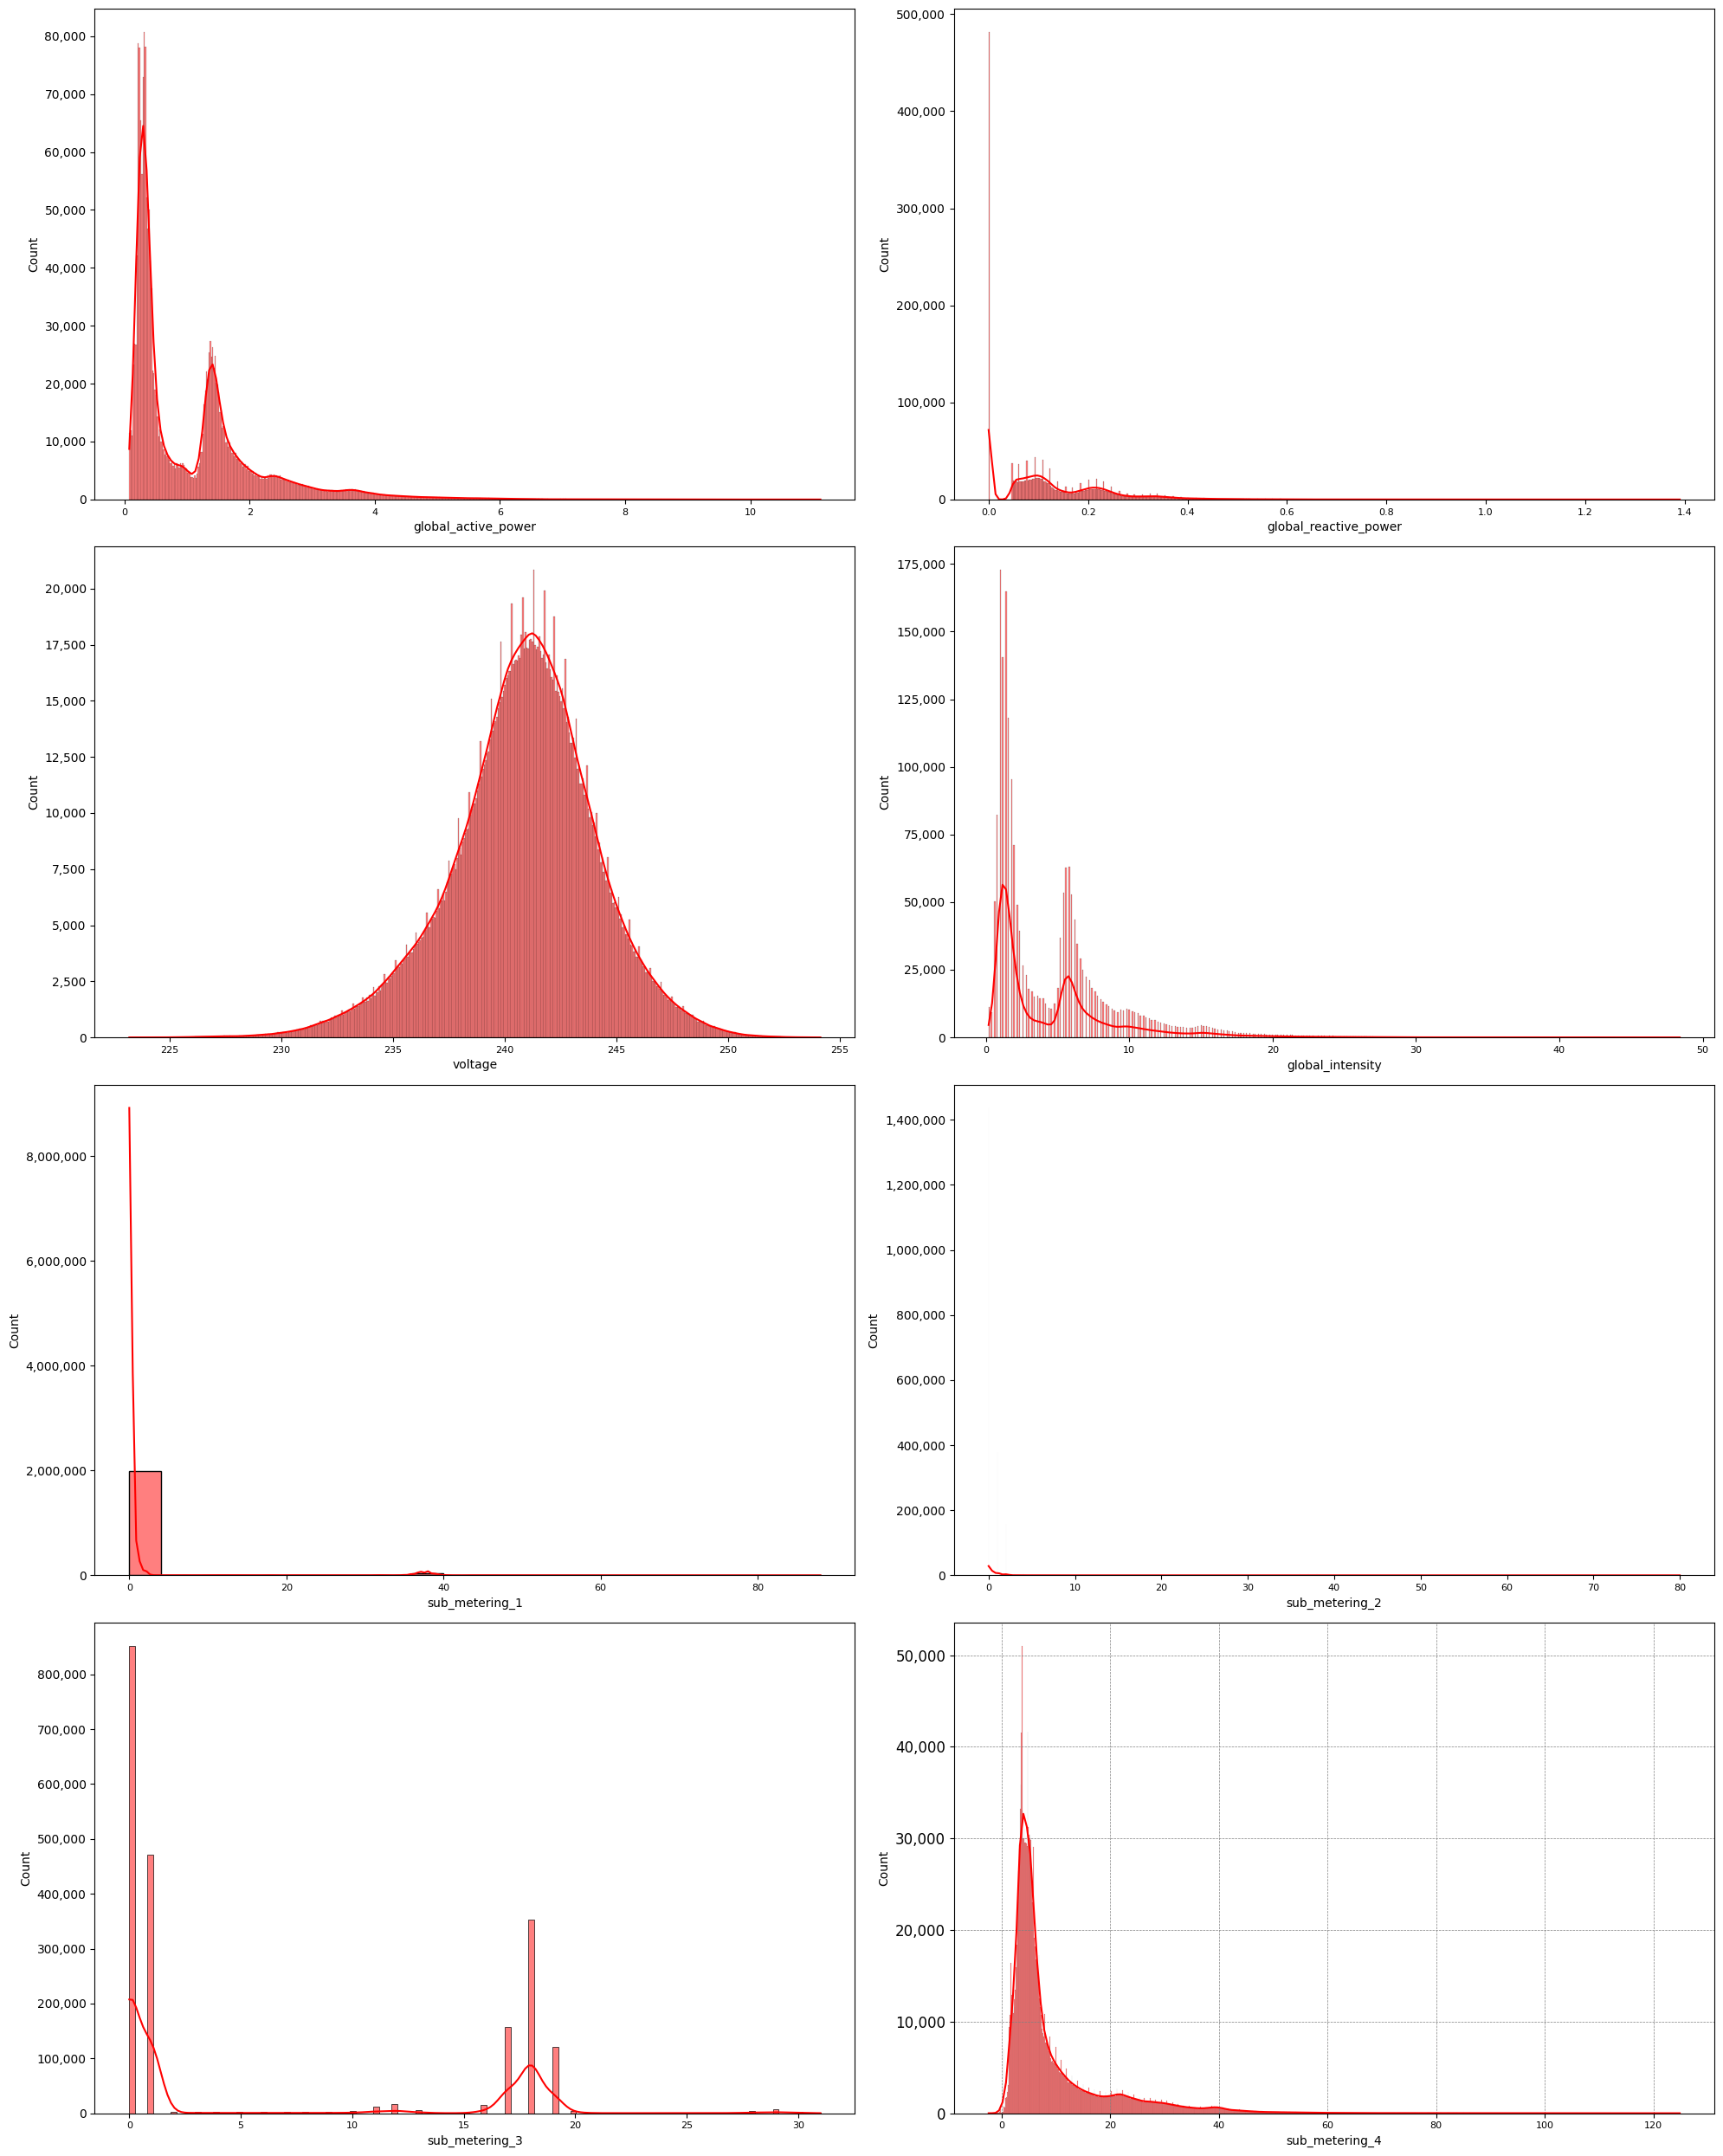

In [24]:
## Histograms: Plotting feature distributions

# Features to plot
columns = df.columns
fig, axes = plt.subplots(4, 2, figsize=(20,25), sharey=False)
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=df, ax=ax,color='r')
    
    plt.xticks(fontsize=12, color='black')  
    plt.yticks(fontsize=12, color='black')  
    plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
plt.show()

**Documentation**
- Voltage is a constant and will therefore be dropped for subsequent analysis

### ➡️Plotting data based on one-Hours sampling rate

In [25]:
hdf=df.drop('voltage',axis=1).resample('H').sum()
hdf.shape

(34589, 7)

In [26]:
hdf.head()

,global_active_power,global_reactive_power,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_4
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,651.6,0.0,19.0,607.0,1907.733333
2006-12-16 18:00:00,217.932,4.802,936.0,0.0,403.0,1012.0,2217.200000
2006-12-16 19:00:00,204.014,5.114,870.2,0.0,86.0,1001.0,2313.233333
2006-12-16 20:00:00,196.114,4.506,835.0,0.0,0.0,1007.0,2261.566667
2006-12-16 21:00:00,183.388,4.600,782.8,0.0,25.0,1033.0,1998.466667


In [27]:
hdf.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,34589.0,64.674459,53.995513,0.0,20.218,46.948,94.206000,393.632000
global_reactive_power,34589.0,7.329660,4.066808,0.0,4.618,6.364,8.920000,46.460000
global_intensity,34589.0,274.178918,226.097083,0.0,89.400,200.400,393.800000,1703.000000
sub_metering_1,34589.0,66.470121,211.089850,0.0,0.000,0.000,0.000000,2902.000000
sub_metering_2,34589.0,76.932869,250.148948,0.0,0.000,19.000,39.000000,2786.000000
sub_metering_3,34589.0,382.640926,440.306805,0.0,38.000,99.000,837.000000,1293.000000
sub_metering_4,34589.0,551.863734,496.964205,0.0,259.300,341.200,658.166667,3890.233333


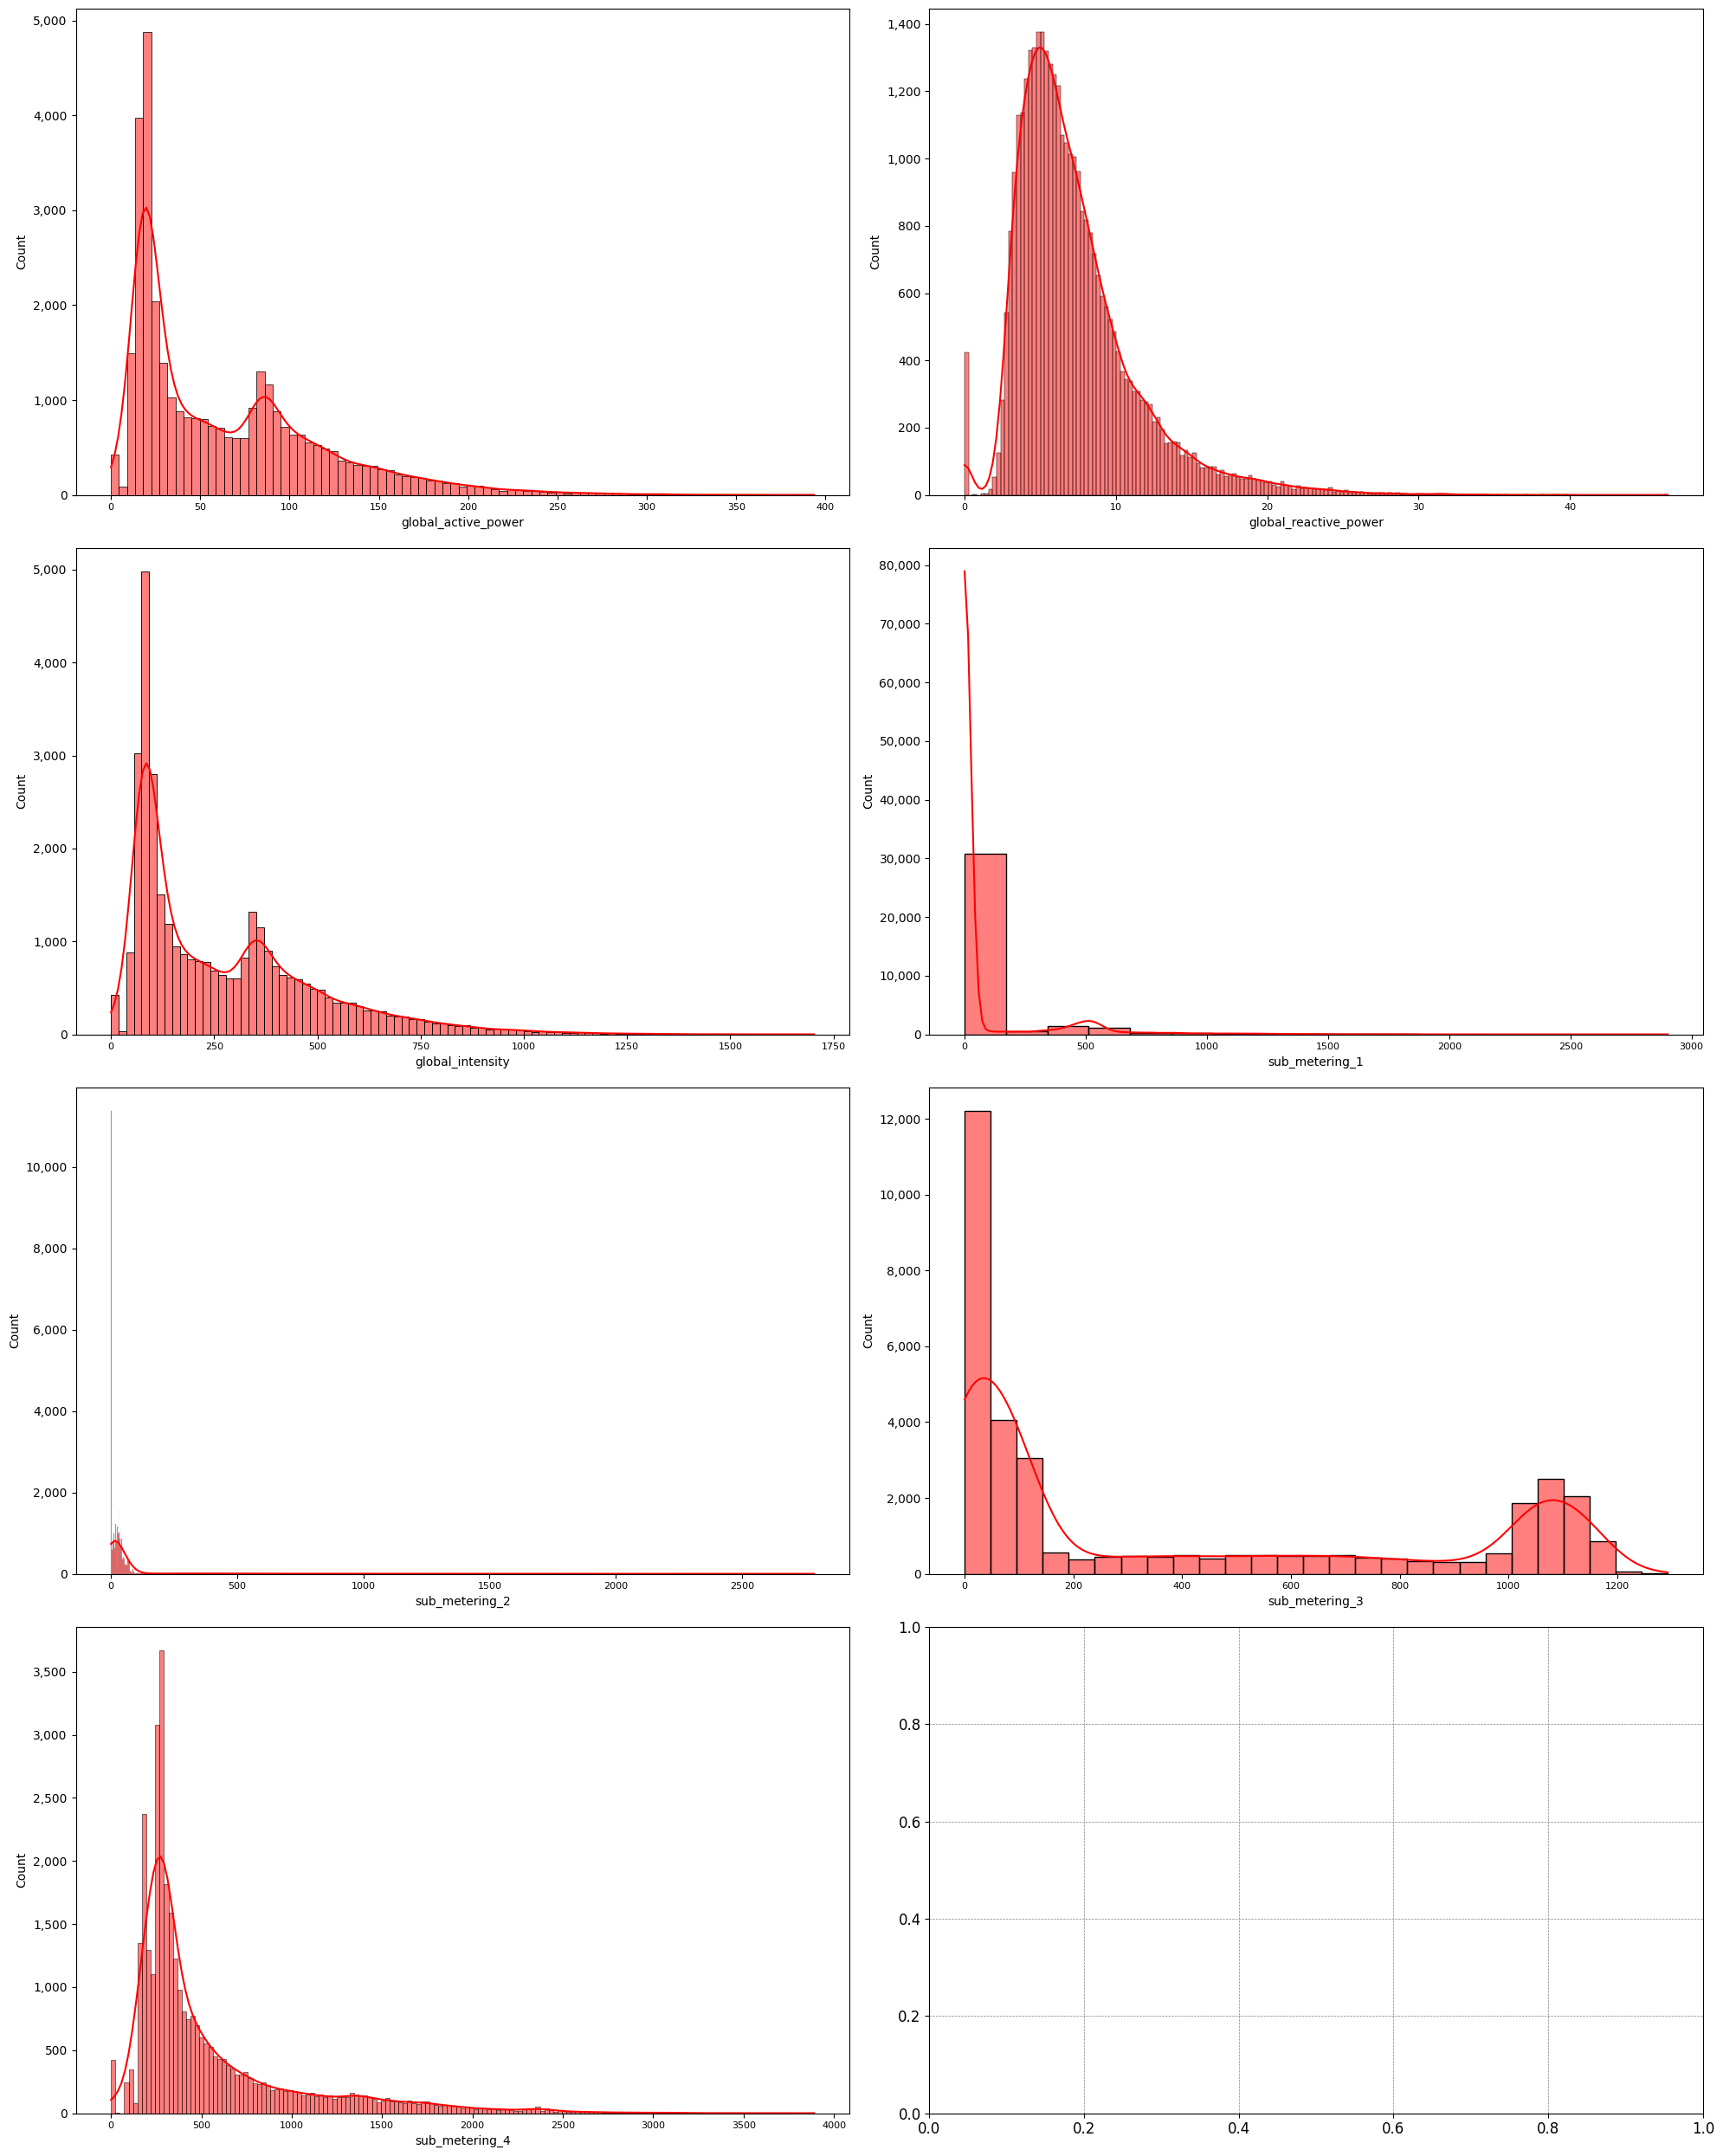

In [28]:
## Histograms: Plotting feature distributions

# Features to plot
columns = hdf.columns
fig, axes = plt.subplots(4, 2, figsize=(20,25), sharey=False)
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=hdf, ax=ax,color='r')
    
    plt.xticks(fontsize=12, color='black')  
    plt.yticks(fontsize=12, color='black')  
    plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
plt.show()

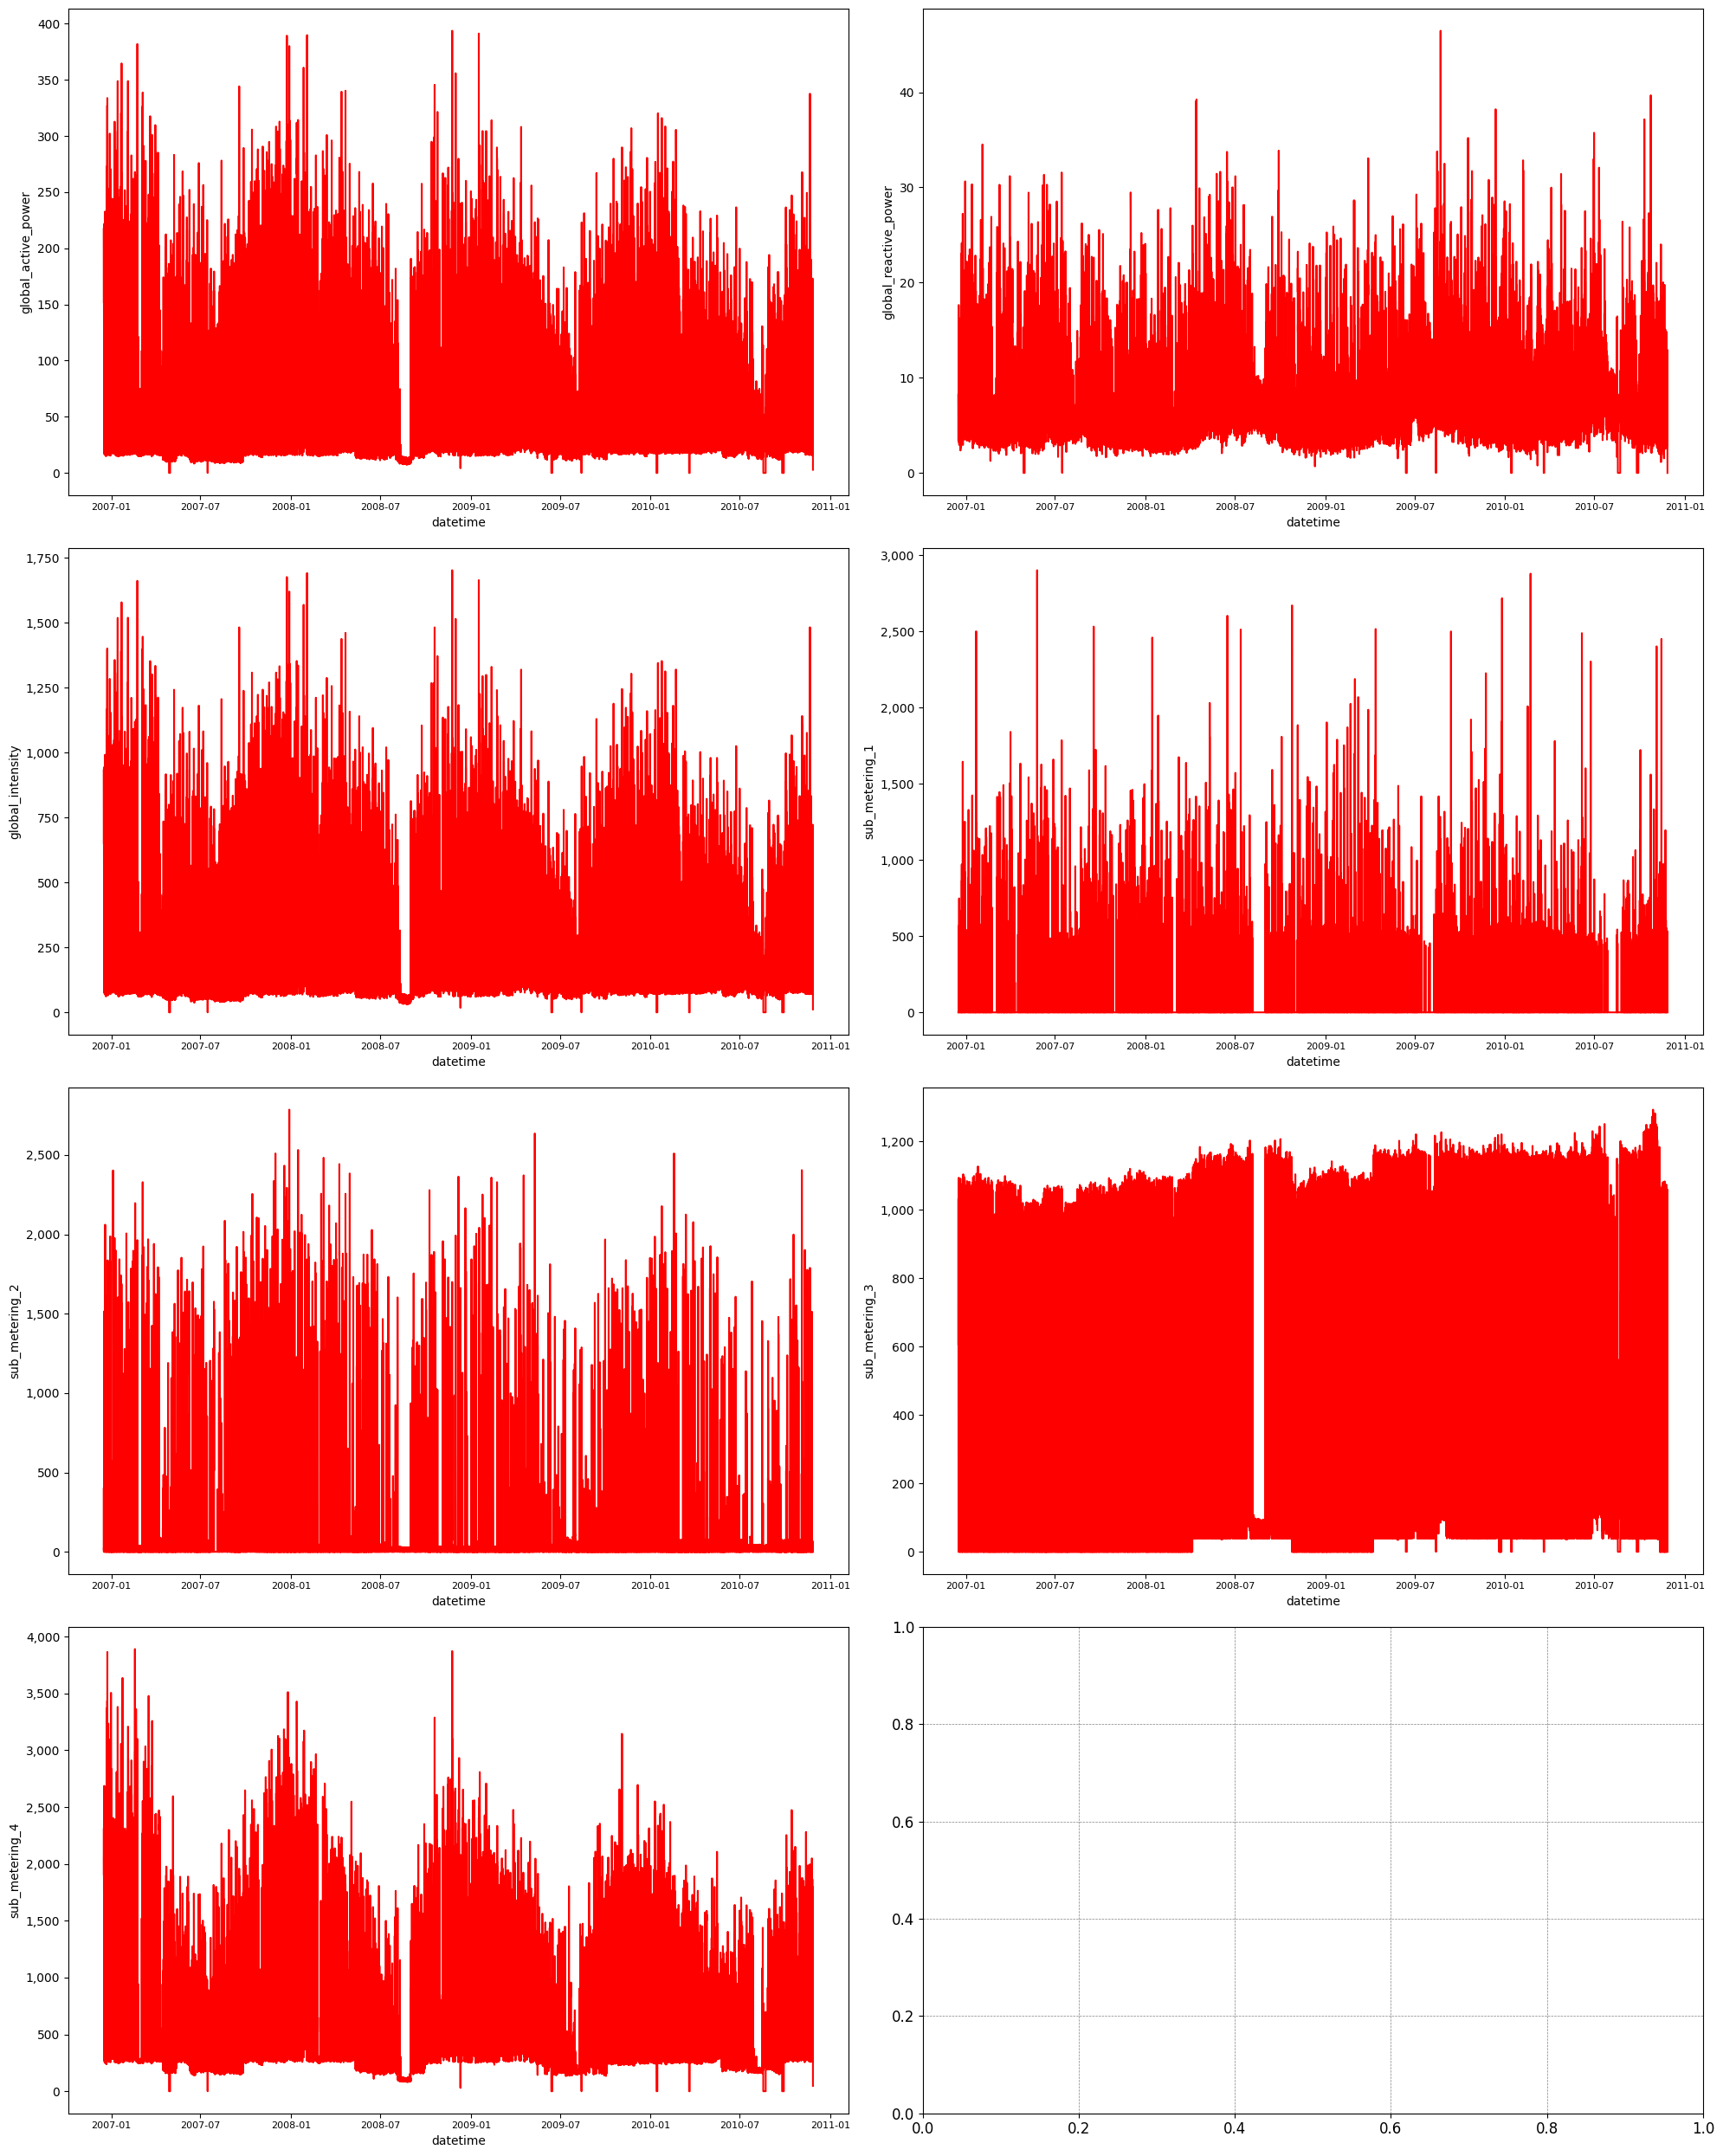

In [29]:
columns = hdf.columns
fig, axes = plt.subplots(4, 2, figsize=(20,25), sharey=False)
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(x=hdf.index,y=col, data=hdf, ax=ax,color='r')
    
    plt.xticks(fontsize=12, color='black')  
    plt.yticks(fontsize=12, color='black')  
    plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
plt.show()

### ➡️Plotting data based on daily sampling rate

In [30]:
ddf=df.drop('voltage',axis=1).resample('D').sum()
ddf.shape

(1442, 7)

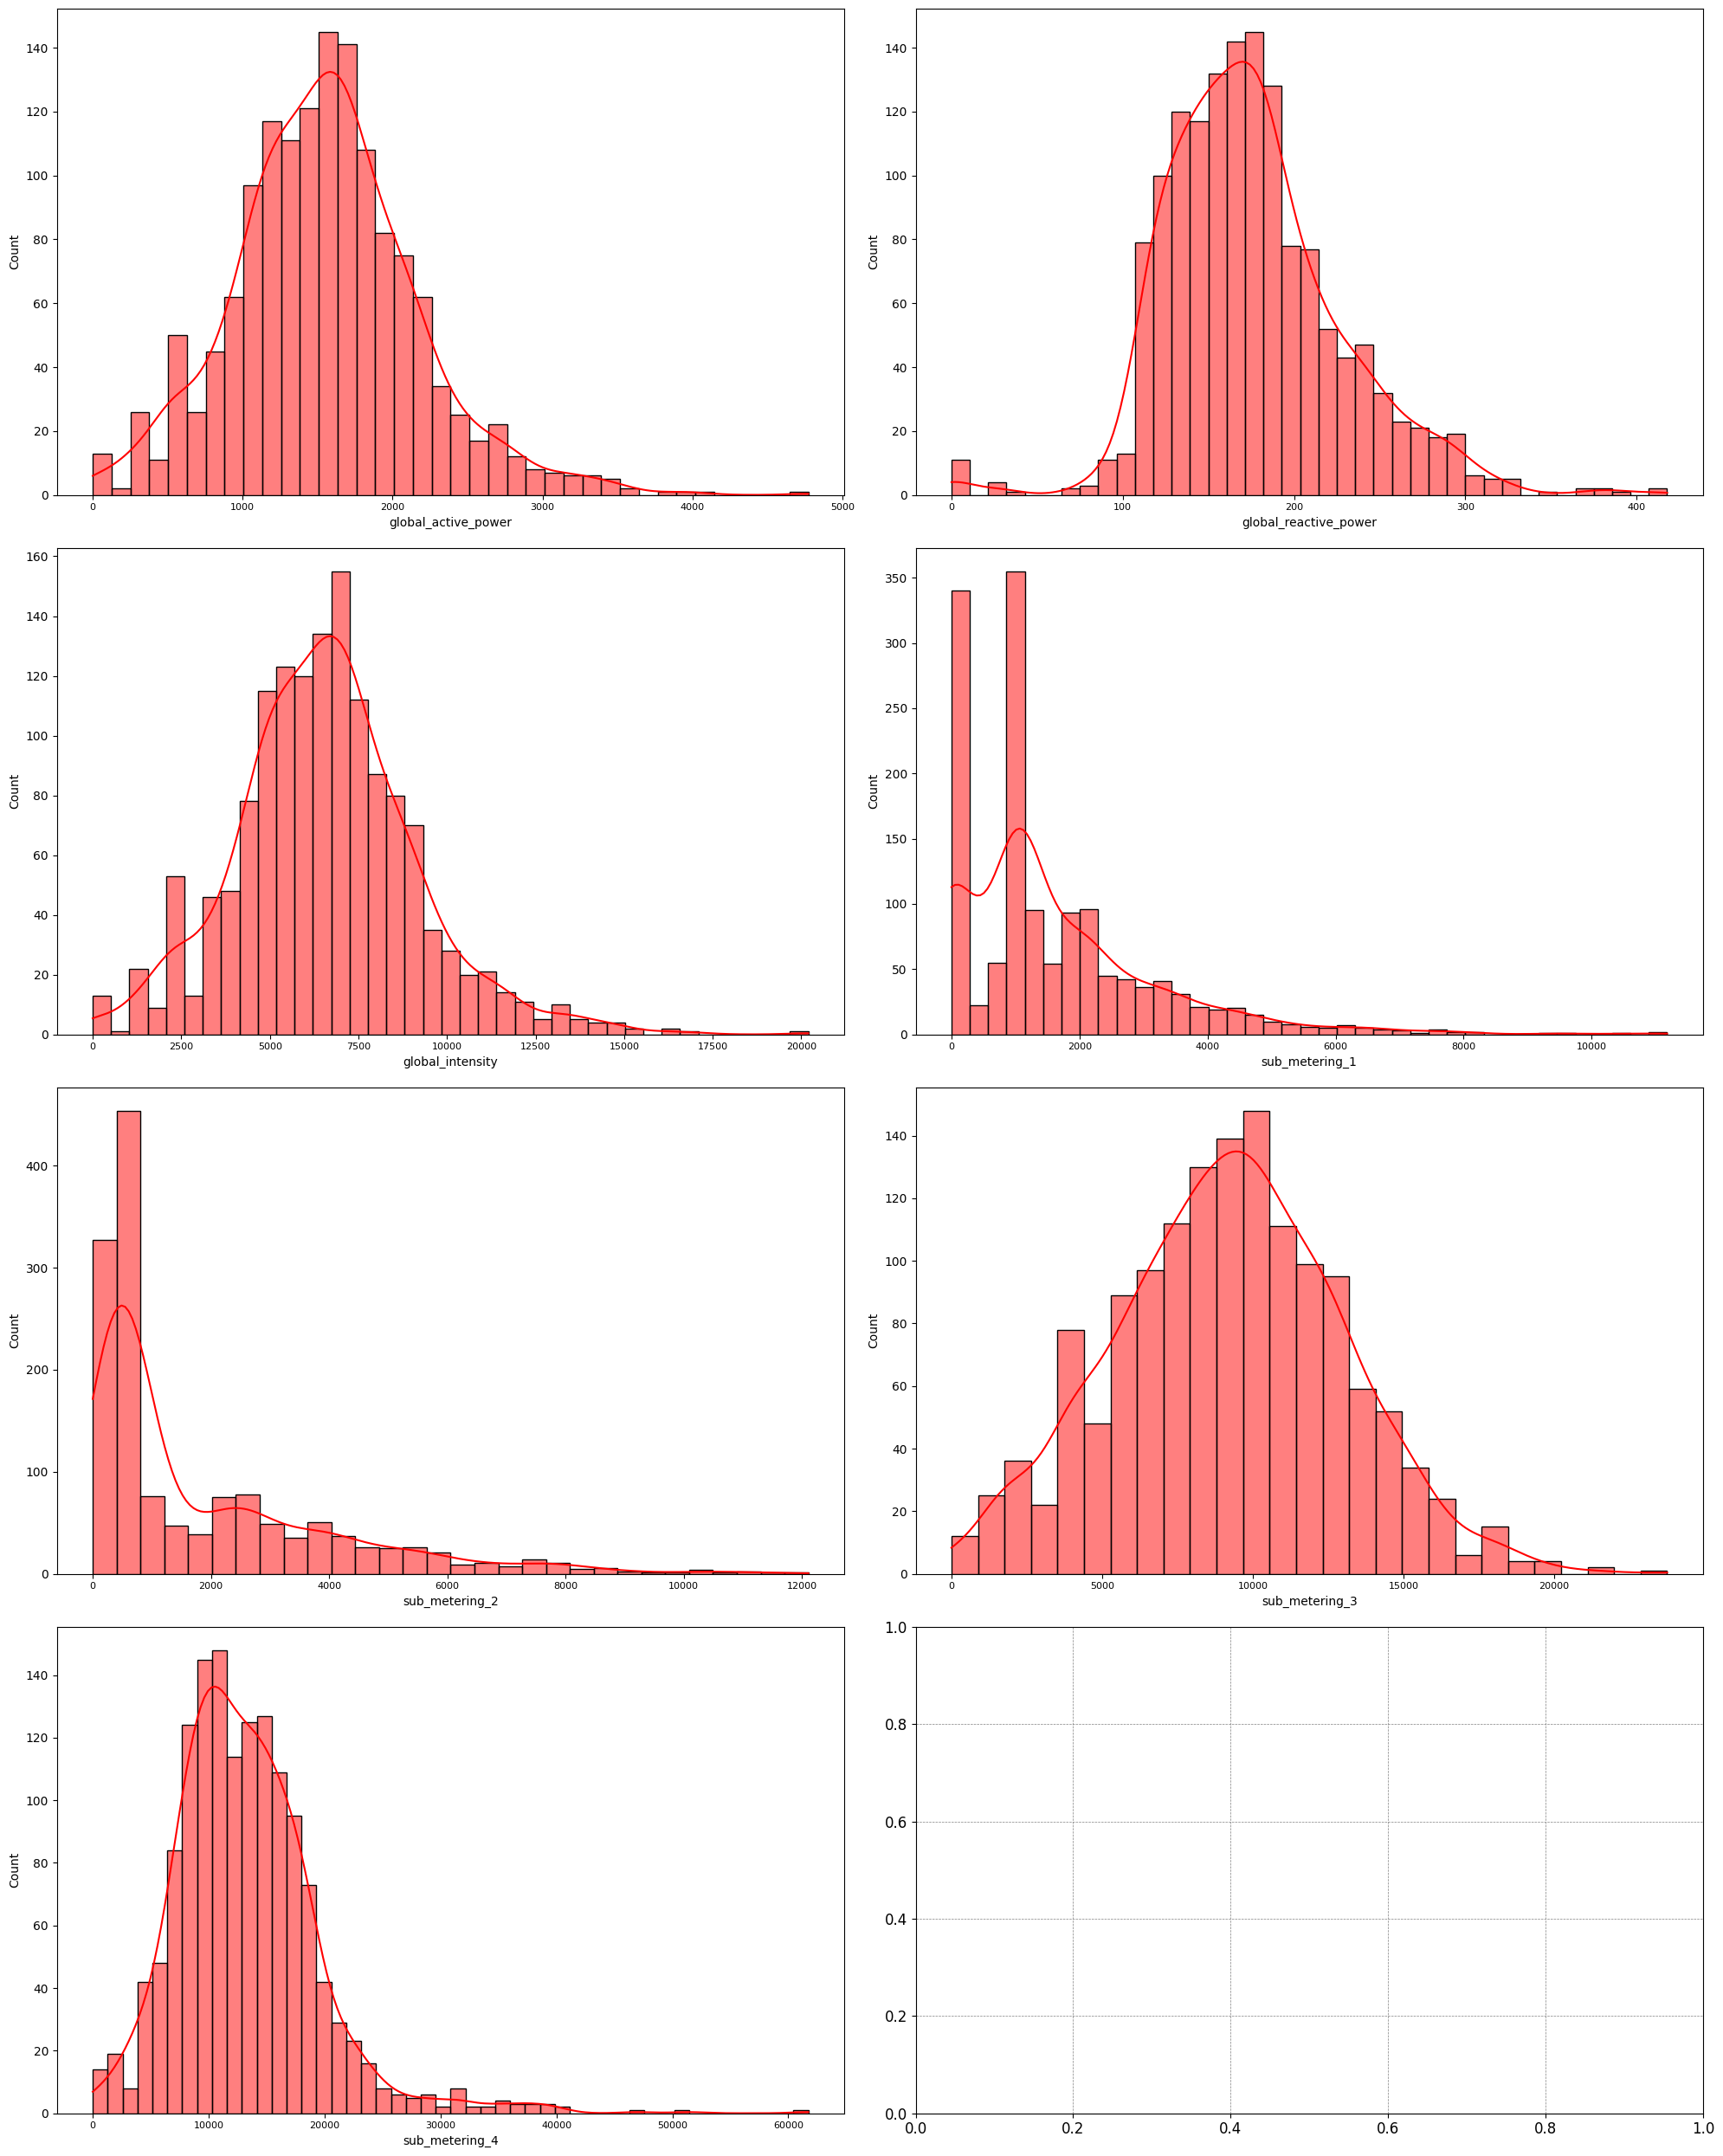

In [31]:
columns = ddf.columns
fig, axes = plt.subplots(4, 2, figsize=(20,25), sharey=False)
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=ddf, ax=ax,color='r')
    plt.xticks(fontsize=12, color='black')  
    plt.yticks(fontsize=12, color='black')  
    plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
plt.show()

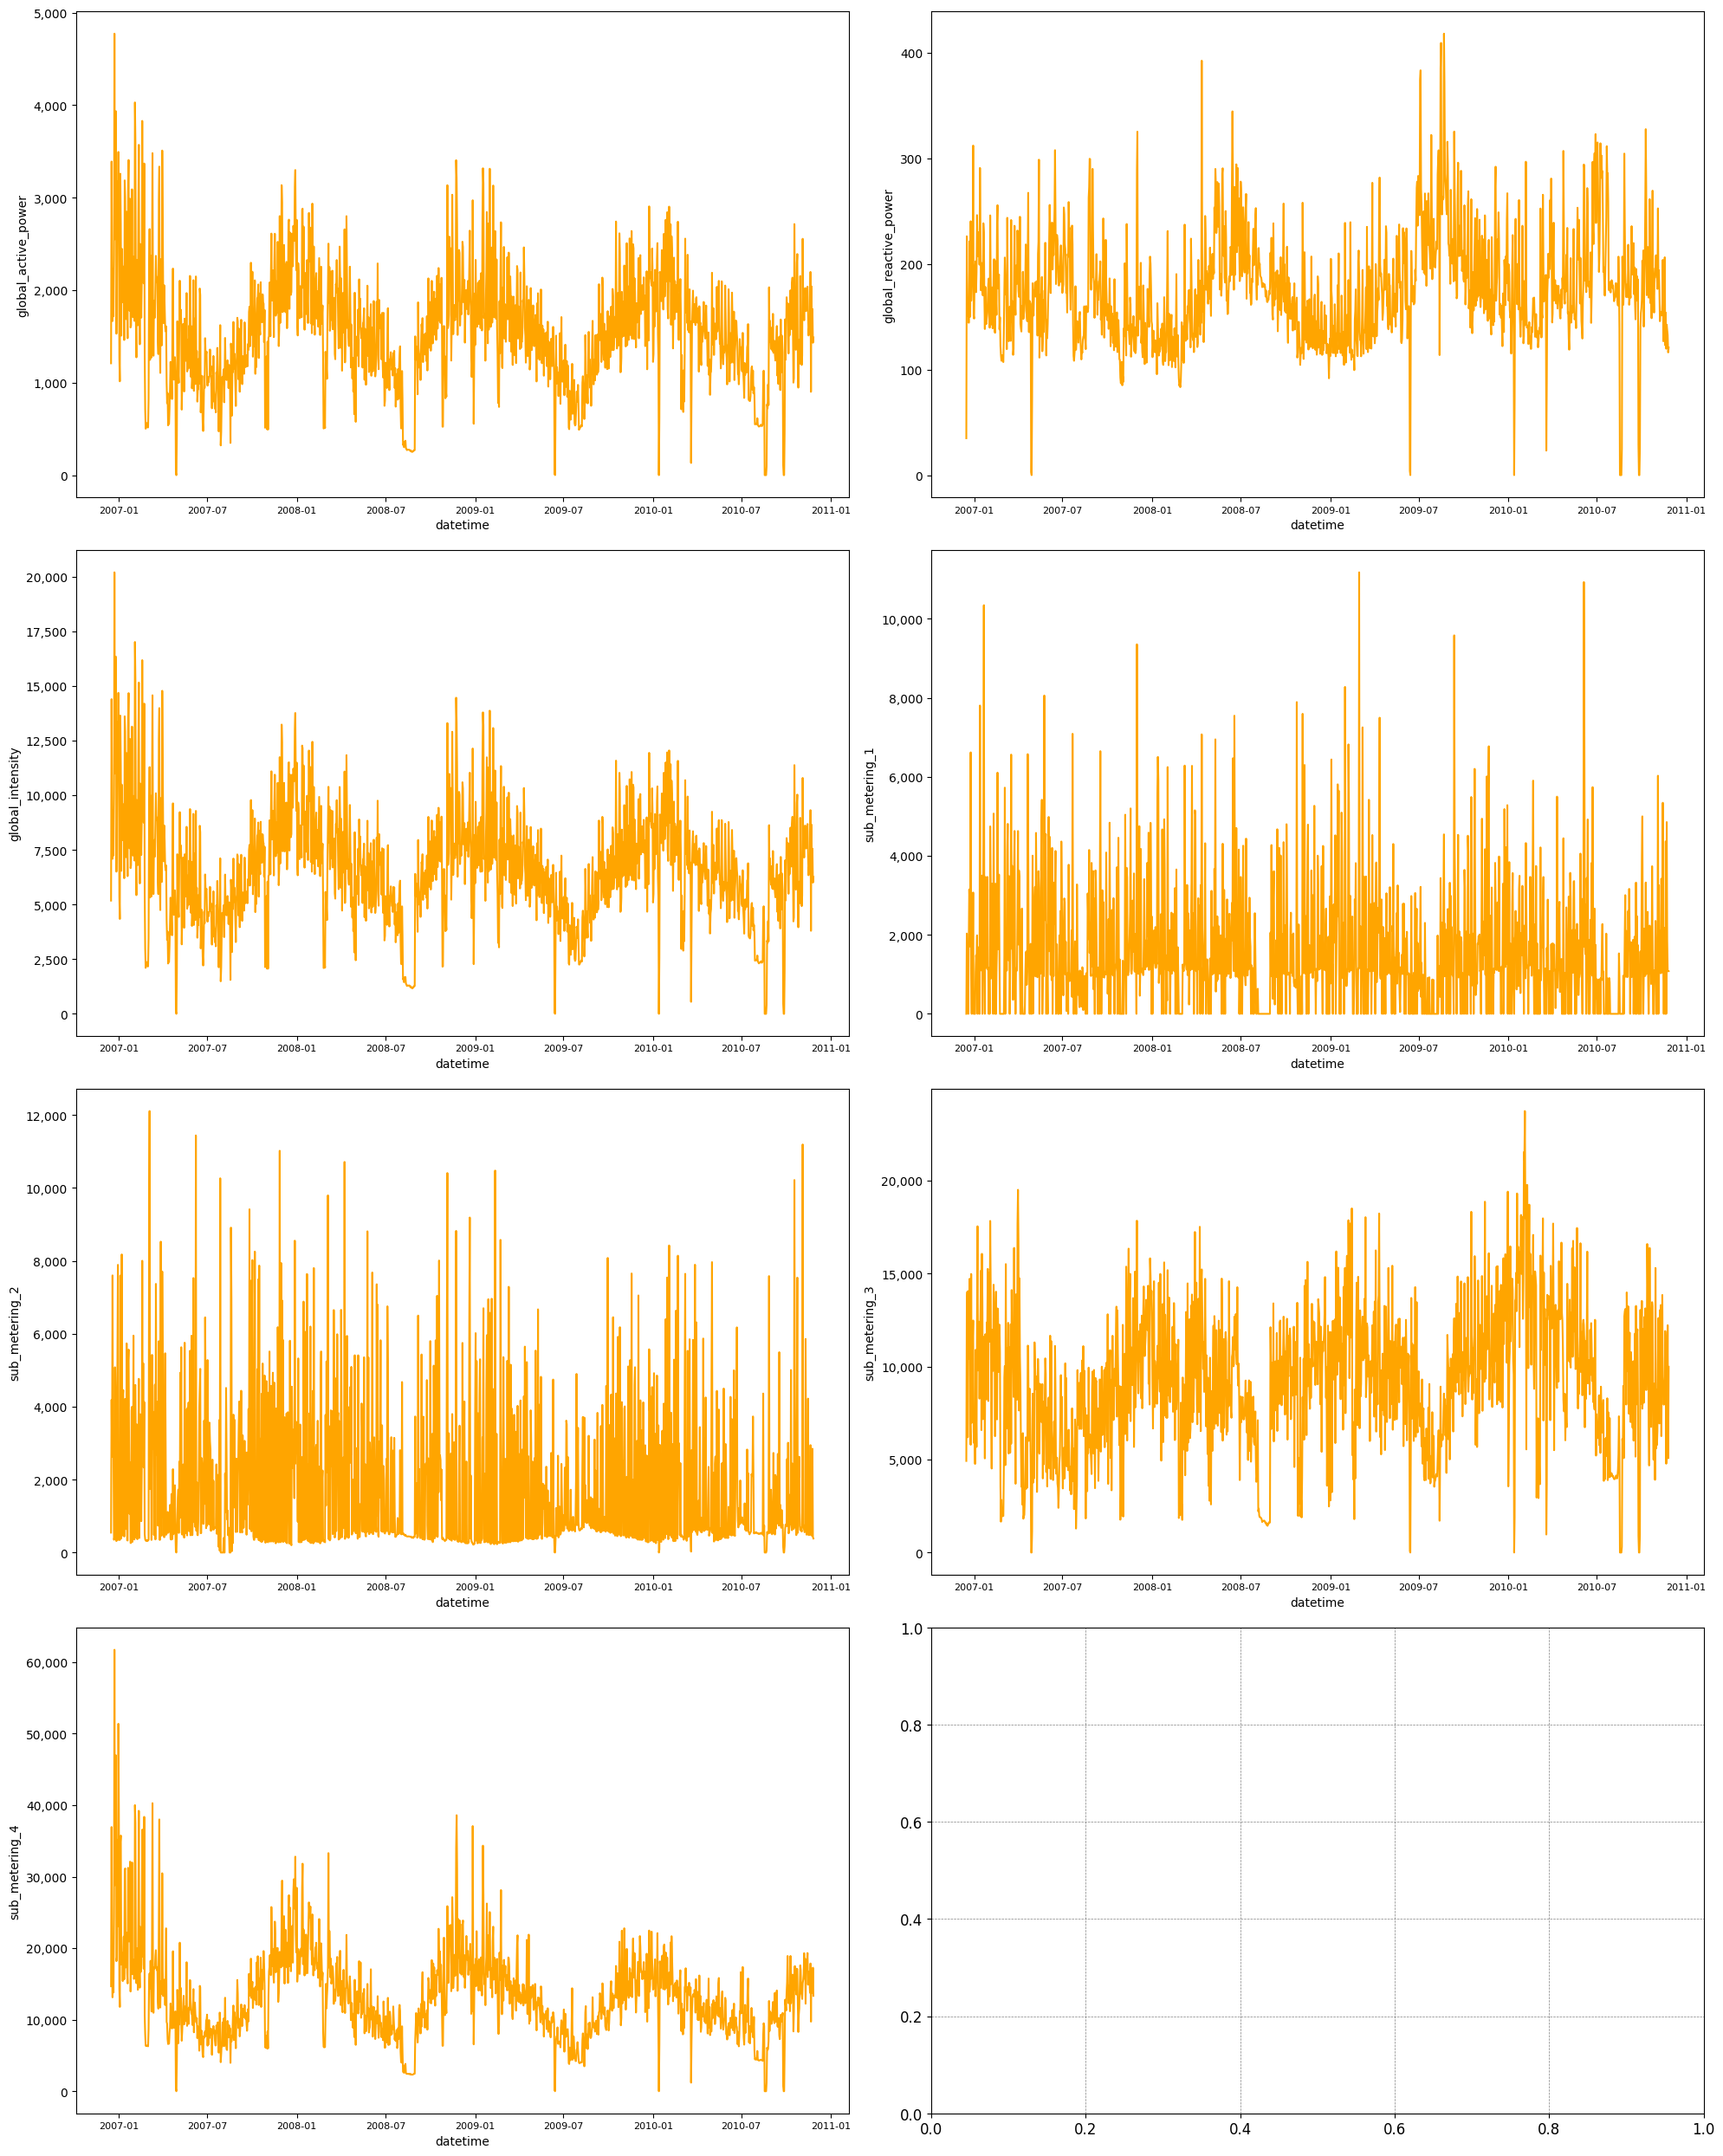

In [32]:
columns = ddf.columns
fig, axes = plt.subplots(4, 2, figsize=(20,25), sharey=False)
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(x=ddf.index,y=col, data=ddf, ax=ax,color='orange')
    plt.xticks(fontsize=12, color='black')  
    plt.yticks(fontsize=12, color='black')  
    plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout()
plt.show()

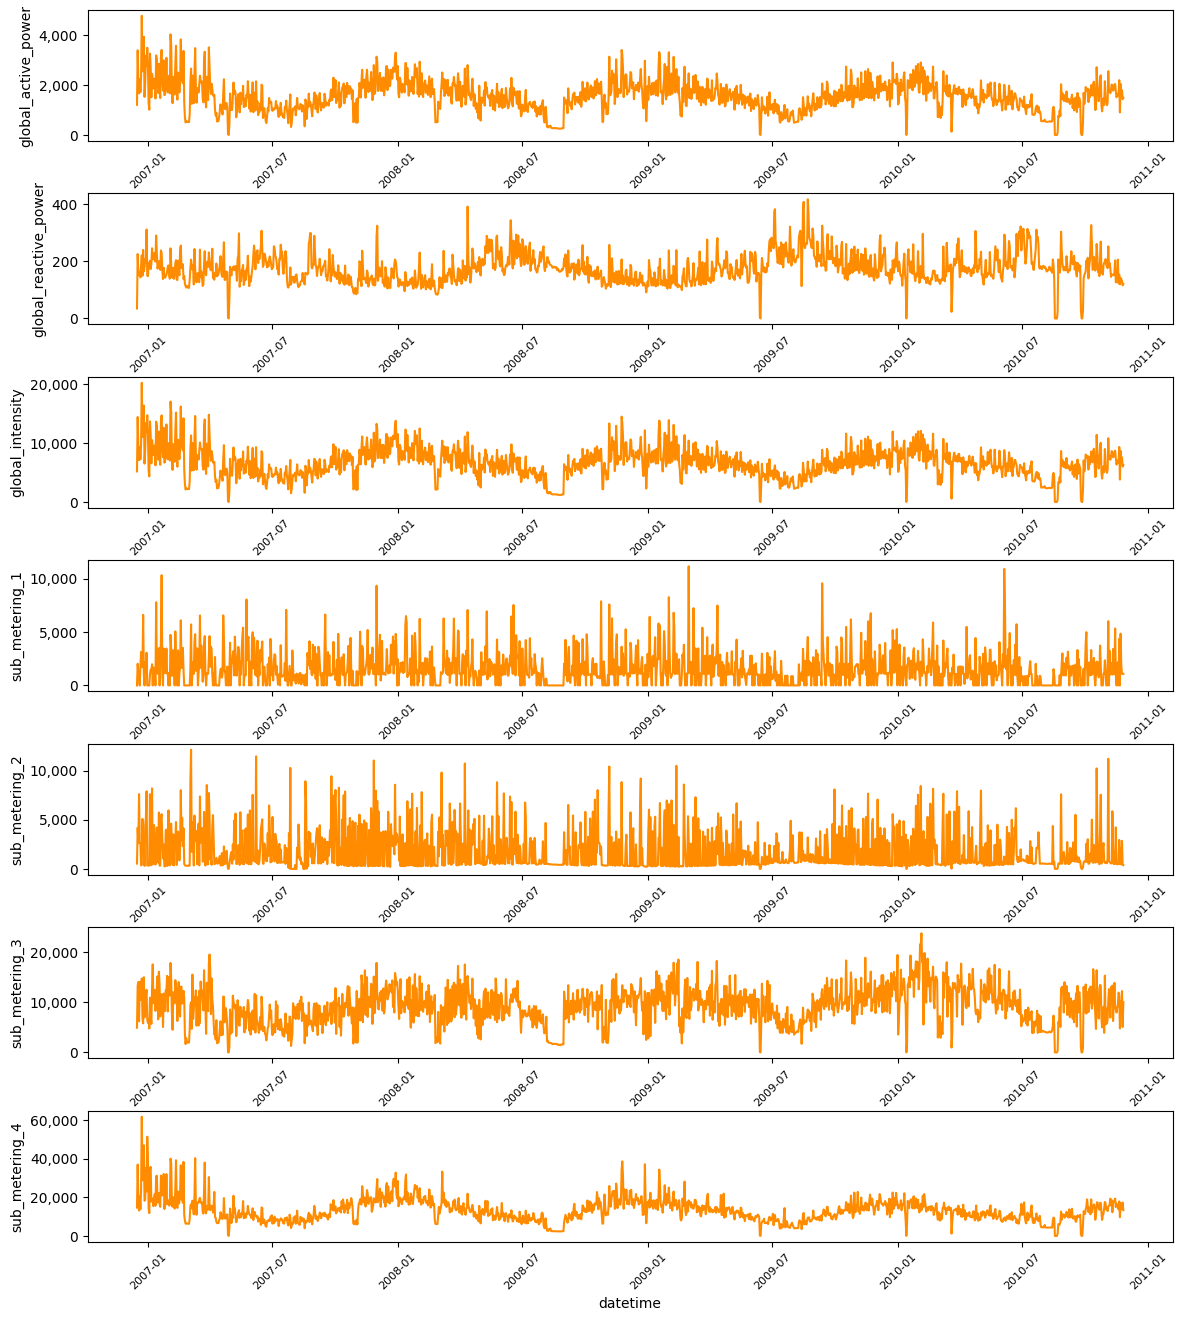

In [33]:
## Plotting features over time (with a different aspect ratio)

# Features to plot
columns = ddf.columns

# Creating subplot axes
fig, axes = plt.subplots(7, 1, figsize=(14,16), sharey=False)

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=ddf, x=ddf.index, y=col, ax=ax, color='darkorange')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

**Documentation**
* Target variable 'global_active_power' (total daily power consumption): time-series is stationary and shows seasonality. However, variance shows some variability. Exclude the first couple of months for modelling?

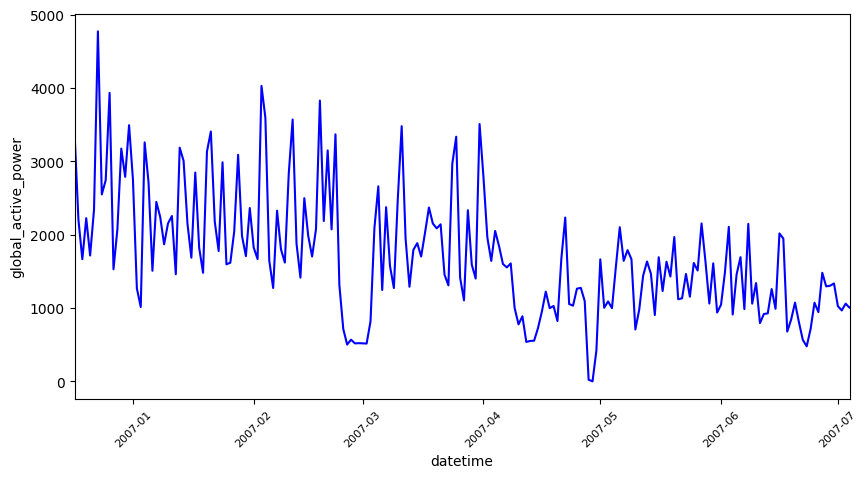

In [34]:
plt.figure(figsize=(10,5))
sns.lineplot(data=ddf,x=ddf.index,y='global_active_power',color='blue')
plt.tick_params(axis='x', labelrotation=45, labelsize=8)
plt.xlim([ddf.index[1], ddf.index[200]]);

**Documentation**
* Exclude the first 5 months for modelling?

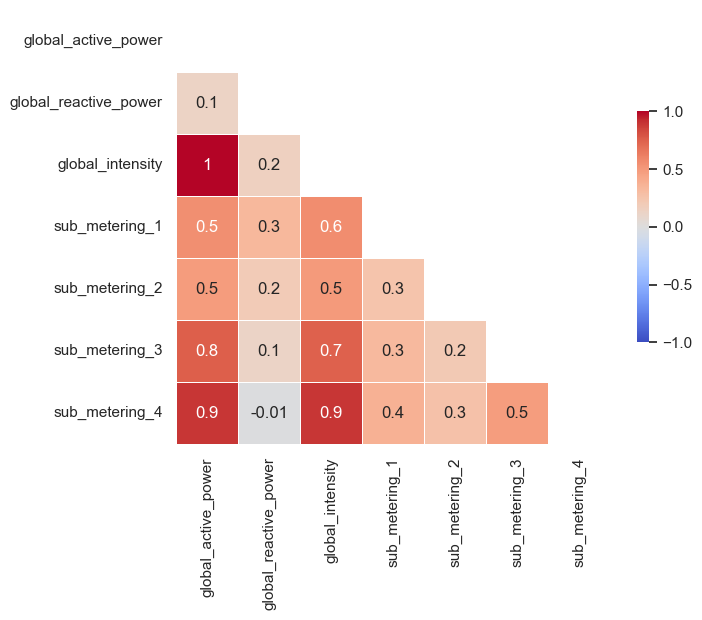

In [35]:
## Correlation heatmap
sns.set_theme(style="white")
plt.subplots(figsize=(7,6))

# Generate mask for upper triangle
mask = np.zeros_like(ddf.corr(), dtype=bool) #generate mask of "0's"
mask[np.triu_indices_from(mask)] = True #return upper triangle
# Set diverging colormap
cmap = sns.color_palette('coolwarm', as_cmap=True)
# Draw heatmap with mask and correct aspect ratio
sns.heatmap(ddf.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, fmt='.1g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

**Documentation**
* 'global_intensity' is highly correlated with other features and should therefore be dropped before modelling

### **➡️ Stationarity: Augmented Dicky-Fuller test**

A statistical test to identify whether a time series is non-stationary is the augmented Dicky-Fuller test.

**Null hypothesis H$_{0}$: Time series is not stationary due to trend.**

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
results=adfuller(ddf['global_intensity'])


# print Dicky -Fuller test result
print(f'Dicky Fuller test result :{results}\n')

# Print test statistic
print(f'test statistic: {results[0]}\n')

# Print p-value
print(f'P value: {np.round(results[1],3)}\n')

# Print critical values
print(f'critical values:{results[4]}\n') 

# Significant Values
alpha=0.05

if results[1]<alpha:
    print(f'\033[1mp-value < {alpha}: We reject the null hypothesis\nConclusion: Time series is stationary\033[0m')
else:
    print(f'\033[1mp-value > {alpha}: We fail to reject the null hypothesis\nConclusion: Time series is not stationary due to trend\033[0m')

Dicky Fuller test result :(-3.9467980236460165, 0.001716198051917846, 22, 1419, {'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}, 25200.18665044952)

test statistic: -3.9467980236460165

P value: 0.002

critical values:{'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}

p-value < 0.05: We reject the null hypothesis
Conclusion: Time series is stationary


### **➡️ Plotting data based on monthly-sampling rate**

In [38]:
mdf=df.drop(['voltage'],axis=1).resample('M').sum()
mdf.shape

(48, 7)

In [39]:
mdf.head()

,global_active_power,global_reactive_power,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_4
datetime,,,,,,,
2006-12-31,41813.282,2889.436,176594.8,27460.0,48712.0,162951.0,457765.033333
2007-01-31,69011.862,5922.396,292241.2,56433.0,79274.0,329578.0,684912.700000
2007-02-28,56488.886,4581.608,238463.6,47584.0,64604.0,270274.0,559019.433333
2007-03-31,58862.192,5122.184,248772.2,60769.0,104762.0,290361.0,525144.533333
2007-04-30,35181.466,4688.994,151026.2,42078.0,38417.0,189503.0,316359.766667


In [40]:
plt.style.use('ggplot')

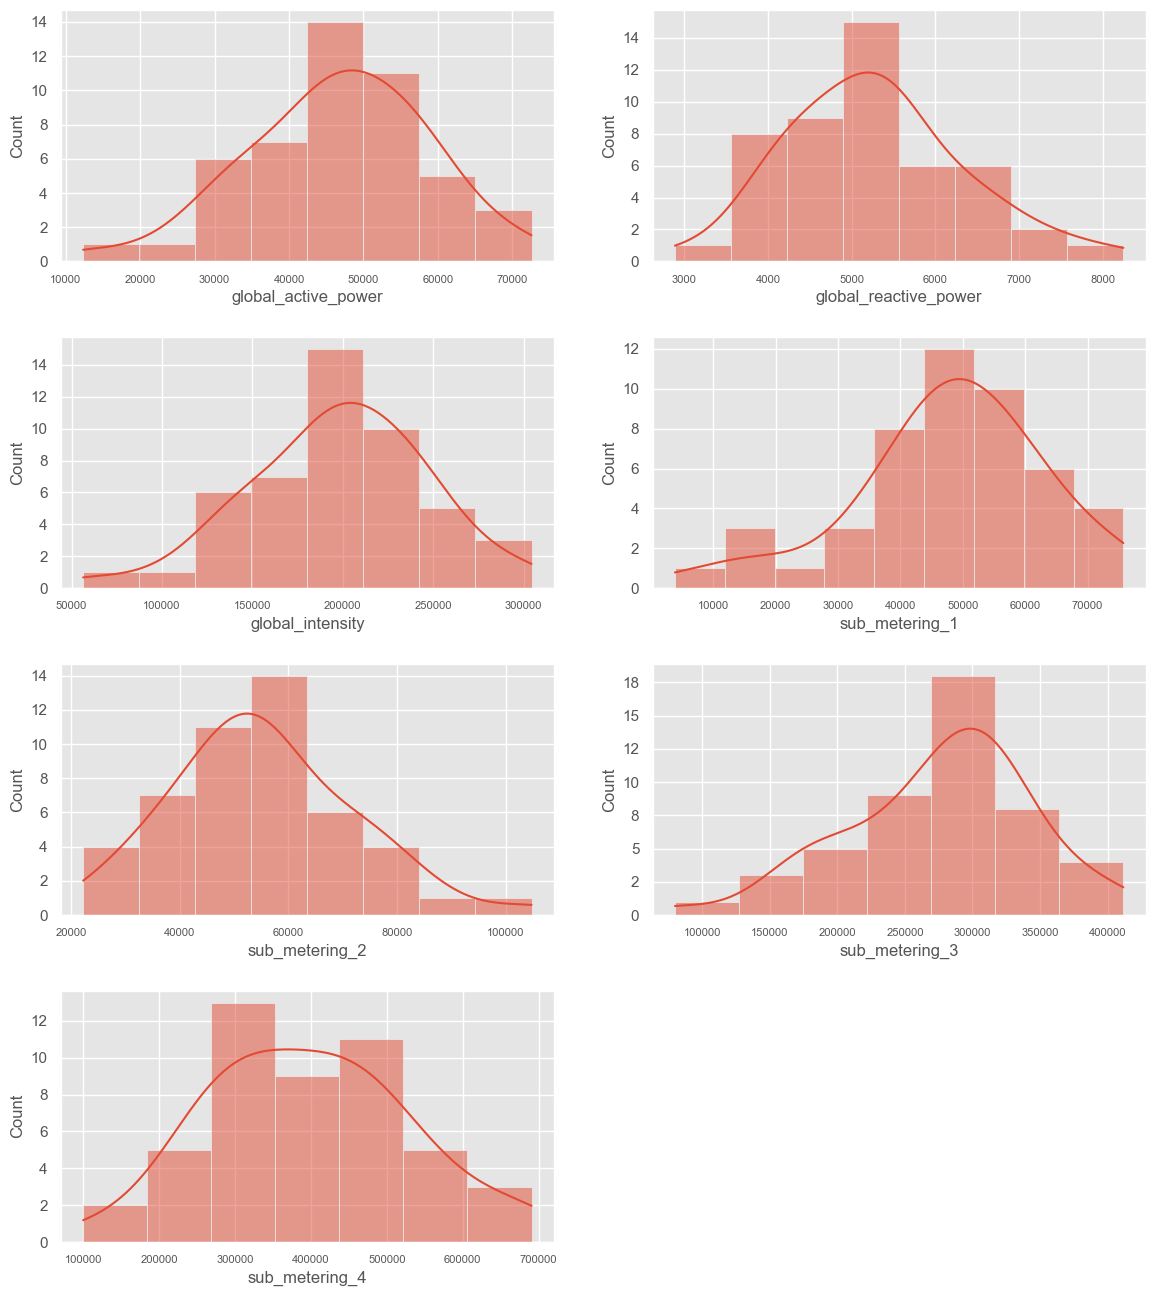

In [41]:
columns = mdf.columns
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=mdf, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

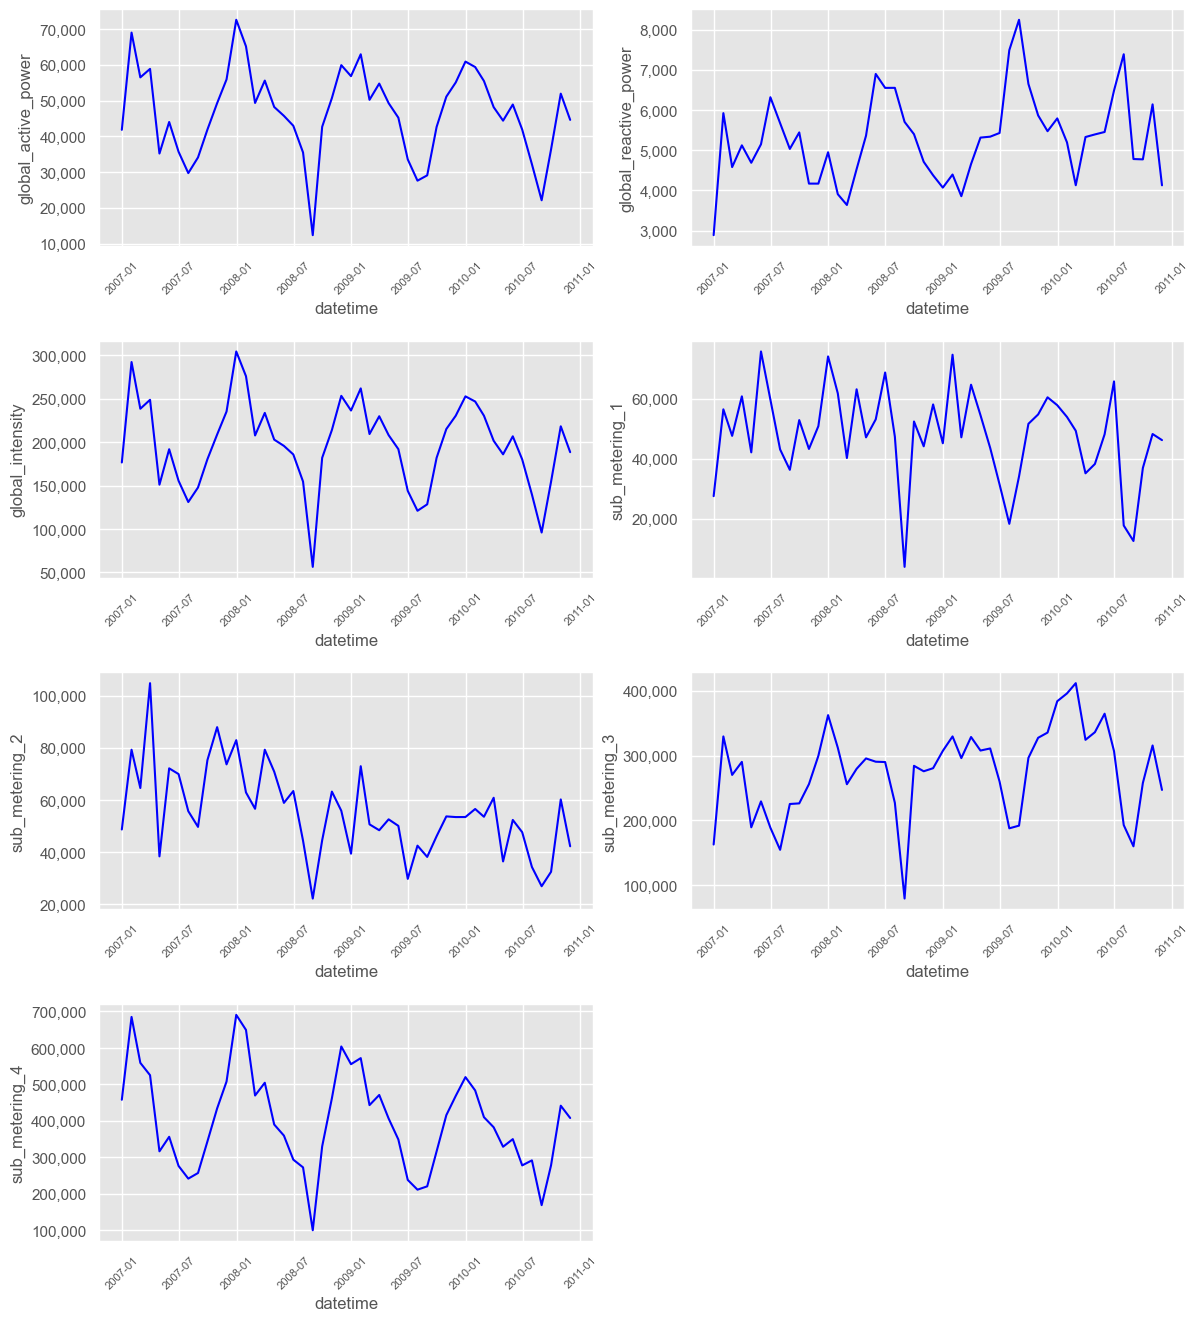

In [42]:
## Plotting features over time
# Features to plot
columns = mdf.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=mdf, x=mdf.index, y=col, ax=ax, color='blue')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

In [44]:
ddf.to_csv(r'data\month_household_power_consumption.csv')

#### LSTM Model
Types of LSTM Models:
* Univariate Single-Step Prediction
* Multivariate Single-Step Prediction
* Univariate Multi-Step Prediction
* Multivariate Multi-Step Prediction

### Split our data

In [53]:
def split_data(data, test_size=0.2, analysis='univariate'):
    """
    Function to split time series data into train and test set
    Parameters:
        test_size: float, default=0.2
        analysis: {'univariate', 'univariate'}, default='univariate'
    """
    if analysis == 'univariate':
        position = int(round(len(data) * (1-test_size)))
        train = np.array(data[:position]).reshape(-1,1)
        test = np.array(data[position:]).reshape(-1,1)
    
    elif analysis == 'multivariate':
        position = int(round(len(data) * (1-test_size)))
        train = data[:position]
        test = data[position:]
    else:
        print("Please specify if analysis is univariate or multivariate")
        
    return train, test

### Scale the data:

In [54]:
def scale(data, train_split):
    """
    Function to scale the entire dataset using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    
    return (data - data_mean) / data_std

In [55]:
def inv_scale(data, scaled_data, train_split):
    """
    Function to inverse scaling of data by using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
       
    return scaled_data * data_std + data_mean

### Create samples
Out in the wild this process is sometimes called create features, to supervised (X, y) or data windowing (input and labels)

**LSTM model type: Univariate multi-step prediction**

In [56]:
def create_samples_univar(data, n_input, n_output):
    """
    Function to convert time series observations
    into input X and output y 
    """
    X, y = [], []
    
    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i])
        y.append(data[i : i+n_output]) 
        
    return np.array(X), np.array(y)

**LSTM model type: Multivariate multi-step prediction**

In [57]:
def create_samples_multivar(data, n_input, n_output, target_index=0):
    """
    Function to convert time series observations
    into input X and output y 
    """
    X, y = [], []
    
    # Move column defined by target_index to first position
    a = data[:, target_index].reshape(-1,1)
    b = np.delete(data, target_index, axis=1)
    data = np.concatenate((a, b), axis=1)
            
    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i, :])
        y.append(data[i : i+n_output, 0]) 
        
    return np.array(X), np.array(y)

### Model evaluation
Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data. 

In [58]:
def summarize_scores(name, score, scores):
    """
    Function to summarize scores
    """
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [59]:
def plot_model(history):
    """
    Function to plot training and validation loss
    """
    plt.figure(figsize=(10,5))
    plt.plot(history.history["loss"], color="r", label="Training Loss")
    plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.ylim([0, max(plt.ylim())])
    plt.title("Training and Validation Loss", fontsize=16);

### Univariate LSTM Models (multi-step prediction)

* Number of features: 1
* Multi-step prediction 

A time series forecasting problem that requires a **prediction of multiple time steps** into the future can be referred to as **multi-step time series forecasting.**
Specifically, these are problems where the forecast horizon or interval is **more than one time step.**
There are **two main types of LSTM models** that can be used **for multi-step forecasting**, which are:

**1. Vector Output Model**

**2. Encoder-Decoder Model**

#### Data Input

In [60]:
# Input data: Global_active_power (total daily consumption)
feature = ddf['global_active_power']
feature.index = ddf.reset_index()['datetime']
feature.head()

datetime
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Name: global_active_power, dtype: float64

#### Data Scaling

LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

In [61]:
# Define train/test split
test_size = 0.25
TRAIN_SPLIT = int(round(len(ddf) * (1-test_size)))
TRAIN_SPLIT

1082

In [62]:
# Get data values
univar_data = feature.values
univar_data

array([1209.176, 3390.46 , 2203.826, ..., 1796.248, 1431.164, 1488.104])

**Note!** The mean and standard deviation should *only* be computed using the training data

In [63]:
# Scale data (using training data)
univar_data_scaled = scale(univar_data, TRAIN_SPLIT)
univar_data_scaled.shape, univar_data_scaled

((1442,),
 array([-0.55706584,  2.86453289,  1.00315886, ...,  0.36382516,
        -0.20885174, -0.1195347 ]))

In [64]:
# Split data into train and test
train, test = split_data(data=univar_data_scaled, test_size=test_size, analysis='univariate')

# Print shape and first 5 values for train set
print("Shape train:", train.shape, "\nShape test:", test.shape, '\n')
print(train[:5])

Shape train: (1082, 1) 
Shape test: (360, 1) 

[[-0.55706584]
 [ 2.86453289]
 [ 1.00315886]
 [ 0.15982027]
 [ 1.03754608]]


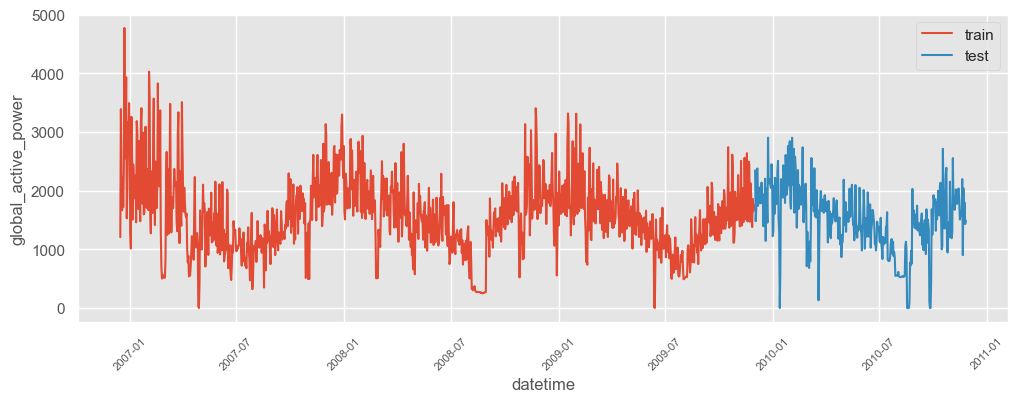

In [65]:
# Visualize train/test split
plt.figure(figsize=(12,4))
plt.plot(ddf.iloc[:len(train), 0])
plt.plot(ddf.iloc[len(train):, 0])
plt.xlabel('datetime')
plt.ylabel("global_active_power")
plt.tick_params(axis='x', labelrotation=45, labelsize=8)
plt.legend(['train','test']);

#### Create Samples

In [66]:
# Create samples for train and test set
n_input = 14
n_output = 7

X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)

# Print shape and first 3 values for train set
print("Shape X_train y_train:", X_train.shape, y_train.shape,
      "\nShape X_test y_test:", X_test.shape, y_test.shape, '\n')
for i in range(2):
    print(X_train[i], y_train[i])

Shape X_train y_train: (1062, 14, 1) (1062, 7, 1) 
Shape X_test y_test: (340, 14, 1) (340, 7, 1) 

[[-0.55706584]
 [ 2.86453289]
 [ 1.00315886]
 [ 0.15982027]
 [ 1.03754608]
 [ 0.23892562]
 [ 1.21886249]
 [ 5.03381385]
 [ 1.54619204]
 [ 1.84910449]
 [ 3.71731142]
 [-0.05576101]
 [ 0.79737516]
 [ 2.525605  ]] [[ 1.92154635]
 [ 3.02725492]
 [ 1.85833423]
 [-0.46285472]
 [-0.86313749]
 [ 2.6589688 ]
 [ 1.80242873]]
[[ 2.86453289]
 [ 1.00315886]
 [ 0.15982027]
 [ 1.03754608]
 [ 0.23892562]
 [ 1.21886249]
 [ 5.03381385]
 [ 1.54619204]
 [ 1.84910449]
 [ 3.71731142]
 [-0.05576101]
 [ 0.79737516]
 [ 2.525605  ]
 [ 1.92154635]] [[ 3.02725492]
 [ 1.85833423]
 [-0.46285472]
 [-0.86313749]
 [ 2.6589688 ]
 [ 1.80242873]
 [-0.08773256]]


In [67]:
train[-5:], test[-5:]

(array([[-0.28906766],
        [ 0.46218057],
        [ 0.1359271 ],
        [ 0.28373472],
        [ 0.30128441]]),
 array([[ 0.74858804],
        [ 0.02074984],
        [ 0.36382516],
        [-0.20885174],
        [-0.1195347 ]]))

In [68]:
X_train[-1], y_train[-1]

(array([[ 0.74693158],
        [-0.15880972],
        [-0.04922615],
        [ 1.56257467],
        [ 0.63215275],
        [-0.07817968],
        [ 0.22585904],
        [ 1.68605305],
        [-0.14032828],
        [ 0.62228301],
        [ 1.46281064],
        [ 1.3908425 ],
        [-0.14617295],
        [ 0.88555966]]),
 array([[ 0.65226556],
        [ 0.05540059],
        [-0.28906766],
        [ 0.46218057],
        [ 0.1359271 ],
        [ 0.28373472],
        [ 0.30128441]]))

In [69]:
X_test[-1], y_test[-1]

(array([[ 0.37819369],
        [ 0.17177627],
        [ 0.40977308],
        [ 0.71809727],
        [ 0.59956631],
        [ 0.32828658],
        [ 0.42747022],
        [ 0.7197851 ],
        [ 0.74365631],
        [ 0.28717313],
        [-0.08558355],
        [ 0.02780234],
        [ 0.13779375],
        [ 0.00955619]]),
 array([[ 0.99246089],
        [-1.04061707],
        [ 0.74858804],
        [ 0.02074984],
        [ 0.36382516],
        [-0.20885174],
        [-0.1195347 ]]))

In [70]:
X_train[0], y_train[0]

(array([[-0.55706584],
        [ 2.86453289],
        [ 1.00315886],
        [ 0.15982027],
        [ 1.03754608],
        [ 0.23892562],
        [ 1.21886249],
        [ 5.03381385],
        [ 1.54619204],
        [ 1.84910449],
        [ 3.71731142],
        [-0.05576101],
        [ 0.79737516],
        [ 2.525605  ]]),
 array([[ 1.92154635],
        [ 3.02725492],
        [ 1.85833423],
        [-0.46285472],
        [-0.86313749],
        [ 2.6589688 ],
        [ 1.80242873]]))

In [71]:
X_test[0], y_test[0]

(array([[ 1.2256546 ],
        [-0.13273617],
        [ 0.23056489],
        [ 1.23521376],
        [ 1.27682288],
        [ 0.27973161],
        [ 0.69423233],
        [ 0.37340627],
        [ 0.7685879 ],
        [ 0.34533744],
        [ 0.39540455],
        [ 0.90117994],
        [ 0.36165106],
        [ 0.58949892]]),
 array([[-0.26577684],
        [ 0.2398009 ],
        [ 0.28297551],
        [ 1.00395572],
        [-0.65904162],
        [ 0.73828223],
        [ 0.5077834 ]]))

### LSTM Model With Univariate Input and Vector Output

Like other types of neural network models, the **LSTM can output a vector directly that can be interpreted as a multi-step forecast.**

Data already has the correct input shape `[samples, timesteps, features]`

In [75]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Flatten,Dropout,RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.backend import clear_session
from tensorflow.random import set_seed
set_seed(42)

In [74]:
clear_session()
n_features = X_train.shape[2]
n_input = X_train.shape[1]
n_output = y_train.shape[1]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(RepeatVector(n_output))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 50)          │         5,050 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 7, 1)           │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,301 (493.36 KB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

In [ ]:
%%time

# Fit model
epochs = 50
verbose = 0
batch_size = 16 #default 32
history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(X_test, y_test))

In [97]:
erl_stoping=EarlyStopping(patience=10,monitor='val_loss')
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=16)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2343 - mae: 0.3678 - val_loss: 0.6873 - val_mae: 0.6246
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2135 - mae: 0.3530 - val_loss: 0.6664 - val_mae: 0.6111
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2022 - mae: 0.3458 - val_loss: 0.6811 - val_mae: 0.6194
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1973 - mae: 0.3400 - val_loss: 0.6909 - val_mae: 0.6251
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1905 - mae: 0.3349 - val_loss: 0.7093 - val_mae: 0.6322
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1967 - mae: 0.3387 - val_loss: 0.7303 - val_mae: 0.6421
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1959 - mae: 0.3394 - val_loss: 0.7099 - val_mae: 0.6301
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1910 - mae: 0.3319 - val_loss: 0.7170 - val_mae: 0.6349
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1918 - mae: 

<Axes: >

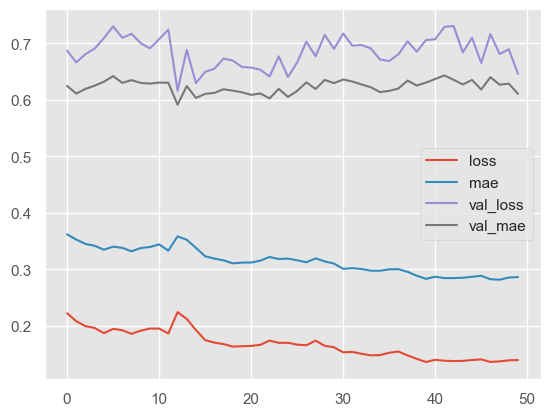

In [98]:
pd.DataFrame(history.history).plot()

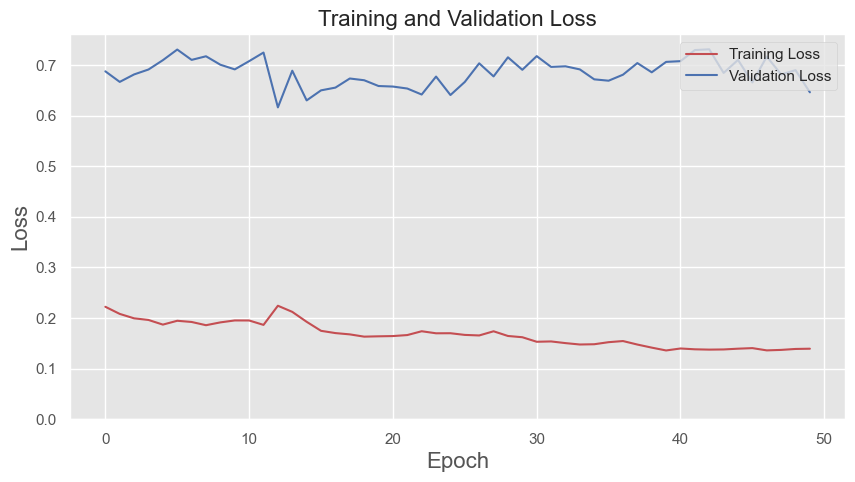

In [99]:
plot_model(history)

In [100]:
# Loss and mae value for the model in test mode
score = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test loss: {score[0]:.4f}') 
print(f'Test mae: {score[1]:.4f}')

Test loss: 0.6458
Test mae: 0.6105


In [101]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [103]:
history.history["loss"][:5]

[0.22216308116912842,
 0.20809489488601685,
 0.19933919608592987,
 0.19613565504550934,
 0.186945840716362]

In [104]:
history.history["mae"][:5]

[0.36185479164123535,
 0.35266849398612976,
 0.34495022892951965,
 0.34170258045196533,
 0.3346124589443207]

#### Model Prediction

In [105]:
# Reshape data for prediction into [1, n_input, n_features]
x_input = X_test[0].reshape((1, len(X_test[0]), n_features))
x_input.shape

(1, 14, 1)

In [106]:
yhat = model.predict(x_input, verbose=0)

print(yhat.shape)
yhat

(1, 7, 1)


array([[[ 0.08927929],
        [-0.00182631],
        [ 0.4287321 ],
        [ 1.1738931 ],
        [ 1.362452  ],
        [ 0.59995425],
        [-0.53435326]]], dtype=float32)

**Inverse Data Scaling**

In [107]:
# Inverse scaling of prediction
yhat_inv = inv_scale(multivar_data[:,0], yhat, TRAIN_SPLIT) 
print(yhat_inv.shape)
yhat_inv

NameError: name 'multivar_data' is not defined